In [34]:
import numpy as np
import pandas as pd
import os
import cv2
import datetime
import random
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [31]:
def plot_losses(history):
    plt.rcParams['figure.figsize'] = [20, 5]
    f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)

    ax1.set_title('Losses')
    ax1.set_xlabel('epoch')
    ax1.legend(loc="upper right")
    ax1.grid()
    ax1.plot(history['loss'], label='Training loss')
    ax1.plot(history['val_loss'], label='Validation loss')
    ax1.legend()

    plt.show()

In [35]:
def plot_resultados(model, carpeta, height=64, width=64, n=4):
    """
    Muestra comparaciones entre imágenes originales y reconstruidas por el autoencoder.
    """
    # Seleccionar imágenes aleatorias
    archivos = os.listdir(carpeta)
    archivos_img = random.sample(archivos, n)

    # Cargar y normalizar las imágenes
    imgs_originales = []
    for nombre in archivos_img:
        img = load_img(os.path.join(carpeta, nombre), target_size=(height, width))
        img_array = img_to_array(img) / 255.0  # normalizar a [0,1]
        imgs_originales.append(img_array)

    imgs_originales = np.array(imgs_originales)

    # Reconstruir con el modelo
    imgs_reconstruidas = model.predict(imgs_originales)

    # Mostrar resultados
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # Imagen original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs_originales[i])
        ax.set_title("Original")
        ax.axis("off")

        # Imagen reconstruida
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(imgs_reconstruidas[i])
        ax.set_title("Reconstruida")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

## Image analysis

We plot some of the images

In [14]:
# image_dir = '/kaggle/input/animefacedataset/images'

# # Load image file paths
# image_files = [os.path.join(image_dir, f) for f in os.listdir(image_dir)]

# # Read images and collect their shapes
# images = []
# shapes = []
# for file in image_files:
#     img = cv2.imread(file)
#     if img is not None:
#         images.append(img)
#         shapes.append(img.shape)

# # Check if all shapes are the same
# all_same_shape = all(shape == shapes[0] for shape in shapes)
# print("All images same shape:", all_same_shape)
# print("Image shape (height, width, channels):", shapes[0])

# # Plot the first 4 images
# fig, axs = plt.subplots(1, 4, figsize=(16, 4))
# for i in range(min(4, len(images))):
#     img_rgb = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
#     axs[i].imshow(img_rgb)
#     axs[i].axis('off')
#     axs[i].set_title(f'Image {i+1}')
# plt.tight_layout()
# plt.show()


KeyboardInterrupt: 

In [ ]:
# pd.Series(shapes).value_counts()

Shapes.value_counts()
```
(92, 92, 3)      1636
(96, 96, 3)      1556
(94, 94, 3)      1534
(95, 95, 3)      1530
(90, 90, 3)      1516
                 ... 
(87, 88, 3)         1
(220, 220, 3)       1
(126, 127, 3)       1
(101, 102, 3)       1
(181, 181, 3)       1
Name: count, Length: 181, dtype: int64
```

# Autoencoder

## Defining Hiperparameters

In [15]:
height, width = 64, 64 # Image size, to fit in the competition size
image_dir = '/kaggle/input/animefacedataset'

In [16]:
input_img = keras.Input(shape=(height, width, 3))

# Encoder
x_enc = Conv2D(16, (3, 3), activation="relu", strides=2, padding="same")(input_img)
x_enc = Conv2D(32, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(64, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(128, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
x_enc = Conv2D(256, (3, 3), activation="relu", strides=2, padding="same")(x_enc)
shape_before_flattening = keras.backend.int_shape(x_enc)[1:]  # Save shape for reshaping later
x_enc = Flatten()(x_enc)
x_enc = Dense(128, activation="relu")(x_enc)
x_enc = Dense(64, activation="relu")(x_enc)
encoded = Dense(64, activation="relu")(x_enc)

# Decoder
x_dec = Dense(np.prod(shape_before_flattening), activation="relu")(encoded)
x_dec = Reshape(shape_before_flattening)(x_dec)
x_dec = Conv2DTranspose(256, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(128, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(64, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(32, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
x_dec = Conv2DTranspose(16, (3, 3), activation="relu", strides=2, padding="same")(x_dec)
decoded = Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x_dec)


We define the autoencoder, encoder and decoder

In [17]:
autoencoder = keras.Model(input_img, decoded)
encoder = keras.Model(input_img, encoded)
decoder = keras.Model(encoded, decoded)

In [19]:
opt = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(optimizer=opt, loss="mse")

## ImageDataGenerator

To fit with the competition, we will reshape images to 64x64

In [20]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Create training and validation generators using the same seed
train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),  
    batch_size=256,
    class_mode='input',
    subset='training',
    shuffle=True,
    seed=2004  
)

val_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(height, width),
    batch_size=256,
    class_mode='input',
    subset='validation',
    shuffle=False,
    seed=2004
)

Found 50852 images belonging to 1 classes.
Found 12713 images belonging to 1 classes.


## Train

In [23]:
# Fit the autoencoder
h = autoencoder.fit(
    train_generator,
    epochs=6,
    validation_data=val_generator
)

Epoch 1/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 62s 310ms/step - loss: 0.0398 - val_loss: 0.0410
Epoch 2/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 65s 325ms/step - loss: 0.0371 - val_loss: 0.0378
Epoch 3/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 64s 321ms/step - loss: 0.0352 - val_loss: 0.0364
Epoch 4/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 60s 300ms/step - loss: 0.0341 - val_loss: 0.0361
Epoch 5/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 287ms/step - loss: 0.0334 - val_loss: 0.0355
Epoch 6/6
199/199 ━━━━━━━━━━━━━━━━━━━━ 57s 286ms/step - loss: 0.0328 - val_loss: 0.0347


In [ ]:
# hacemos fine tunning para logar un mejor modelo
opt2 = keras.optimizers.Adam(learning_rate=5e-4)
autoencoder.compile(optimizer=opt2, loss="mse")

h = autoencoder.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
  1/199 ━━━━━━━━━━━━━━━━━━━━ 32:39 10s/step - loss: 0.0316

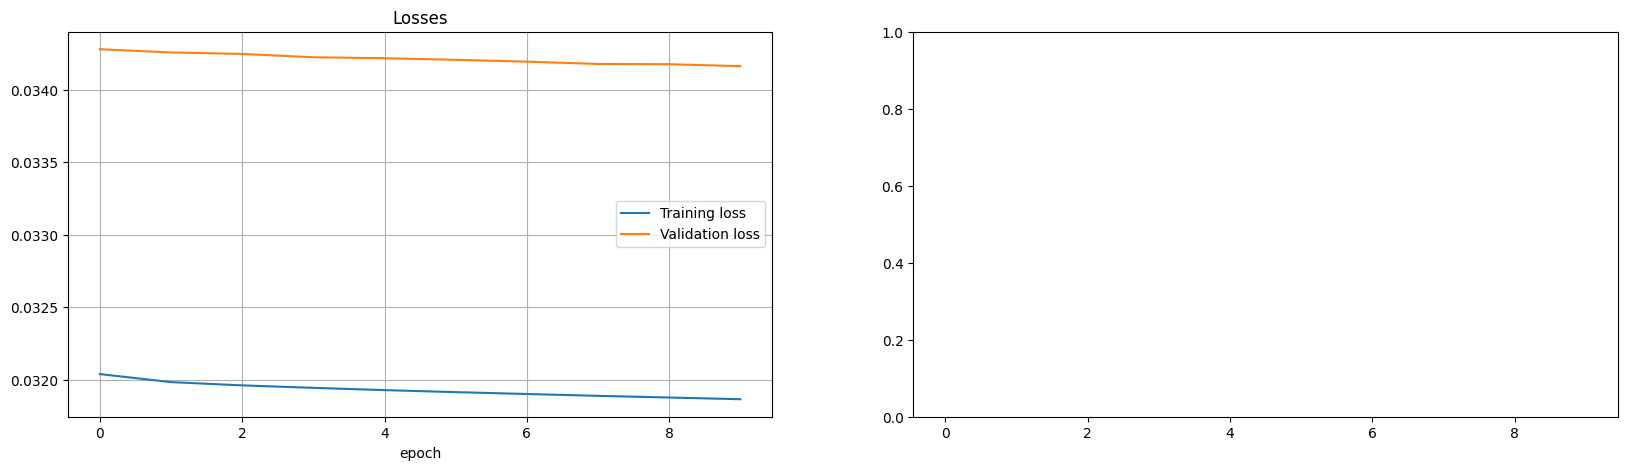

In [38]:
plot_losses(h.history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step


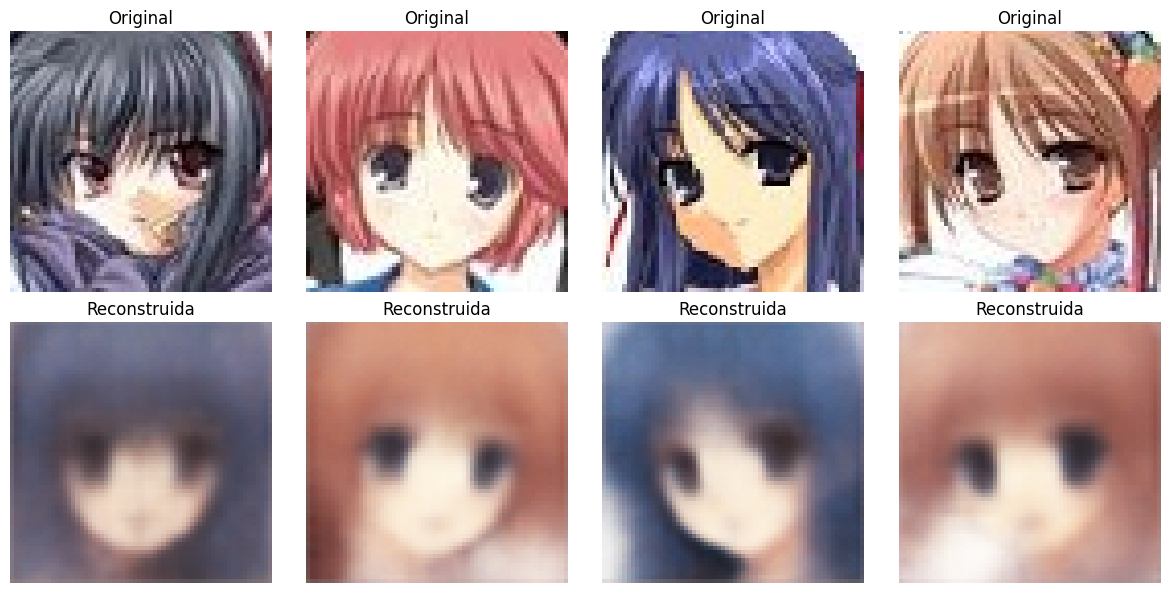

In [39]:
image_dir="/kaggle/input/animefacedataset/images"
plot_resultados(autoencoder,image_dir)

In [ ]:
# Current timestamp
timestamp = datetime.datetime.now().strftime("%m_%d_%H:%M")
## Make sure everything saves correctly
os.makedirs("models", exist_ok=True)

model_path = f"models/autoencoder_{timestamp}.keras"

# Save the model
model.save(model_path)
